In [0]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3989      0 --:--:-- --:--:-- --:--:--  3979
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 337.3MB 48kB/s 
+ set +ex
Installation succeeded!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/HPC2020/project/final

/content/drive/My Drive/HPC2020/project/final


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft, fftshift, ifft

import cupy as cp
from numba import jit
from time import time

In [0]:
Img = Image.open('picture.png').convert('L')

steps = 1000
dTheta = 180.0 / steps

theta = np.arange(0, 181, dTheta)

### Numpy

Getting projections numpy



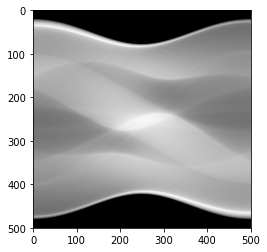

In [5]:
def Proj(img, theta):

  numAngles = len(theta)
  sinogram = np.zeros((img.size[0],numAngles))

  for n in range(numAngles):
    rotation = img.rotate(90-theta[n])
    sinogram[:,n] = np.sum(rotation, axis=0)
      
  return sinogram

print('Getting projections numpy\n')
t1_numpy = time()
Sino = Proj(Img, theta)
t2_numpy = time()-t1_numpy
plt.imshow(Sino, cmap=plt.cm.Greys_r, extent=(0, 500, 500, 0))

https://www.clear.rice.edu/elec431/projects96/DSP/filters.html using conclusions from this article for ProjFilter

Applying filter numpy



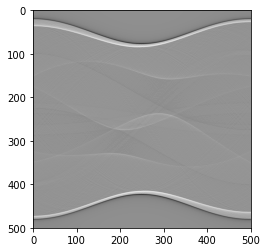

In [9]:
def ProjFilter(sino):
  
    a = 0.9;

    projections, numAngles = sino.shape

    step = 2 * np.pi/projections

    w = np.arange(-np.pi, np.pi, step)

    if len(w) < projections: w = np.concatenate([w, [w[-1]+step]]) 

    rn1 = abs(2/a*np.sin(a*w/2)); 

    rn2 = np.sin(a*w/2)/(a*w/2); 

    r = rn1*(rn2)**2;  
        
    filt = fftshift(r)  

    FiltSino = np.zeros((projections, numAngles))

    for i in range(numAngles):
        ProjFFT = fft(sino[:,i])
        FiltProj = ProjFFT*filt
        FiltSino[:,i] = np.real(ifft(FiltProj))

    return FiltSino

print('Applying filter numpy\n')
t3_numpy = time()
filtSino = ProjFilter(Sino)
t4_numpy = time() - t3_numpy
plt.imshow(filtSino, cmap=plt.cm.Greys_r, extent=(0, 500, 500, 0))

In [10]:
def BackProj(sinogram, theta):

    ImgLen = sinogram.shape[0]
    reconMatrix = np.zeros((ImgLen, ImgLen))
    
    x = np.arange(ImgLen)-ImgLen/2
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    theta = theta*np.pi/180
    numAngles = len(theta)

    T = []
    t1 = time()
    for n in range(numAngles):
        Xrot = X*np.sin(theta[n])-Y*np.cos(theta[n]) #rotated coordinate
        
        XrotCor = np.round(Xrot+ImgLen/2) #back to original image coordinates
        XrotCor = XrotCor.astype('int')
        
        projMatrix = np.zeros((ImgLen, ImgLen))
        
        m0, m1 = np.where((XrotCor >= 0) & (XrotCor <= (ImgLen-1))) #after rotating get new coordinates that exceed the size of the original
        
        s = sinogram[:,n] #get projection
        
        projMatrix[m0, m1] = s[XrotCor[m0, m1]]  # get backprojection in-bounds data
        
        reconMatrix += projMatrix
        T.append(time()-t1)

    backprojArray = np.flipud(reconMatrix)
    return backprojArray,T


print('Implementing backprojection numpy')  
t5_numpy = time()
recon,T_numpy = BackProj(filtSino, theta)
t6_numpy = time() - t5_numpy

Implementing backprojection numpy


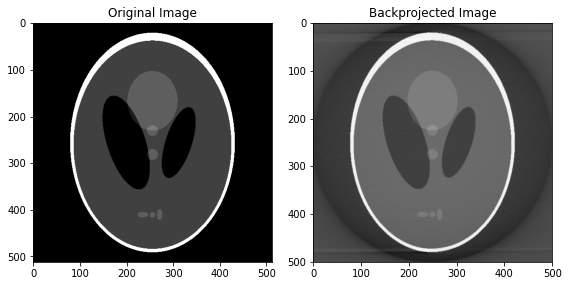

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original Image")
ax1.imshow(Img, cmap=plt.cm.Greys_r)

ax2.set_title('Backprojected Image')
ax2.imshow(recon, cmap=plt.cm.Greys_r, extent=(0, 500, 500, 0))

fig.tight_layout()
plt.show()

### Numba

In [0]:
@jit(nopython=True, forceobj=True)
def Proj(img, theta):
 
  numAngles = len(theta)
  sinogram = np.zeros((img.size[0],numAngles))
 
  for n in range(numAngles):
    rotation = img.rotate(90-theta[n])
    sinogram[:,n] = np.sum(rotation, axis=0)
      
  return sinogram

Img = Image.open('picture.png').convert('L')

steps = 1000
dTheta = 180.0 / steps

theta = np.arange(0, 181, dTheta)

print('Getting projections numba\n')
t1_numba = time()
Sino = Proj(Img, theta)
t2_numba = time()-t1_numba

Getting projections numba



In [0]:
@jit(nopython=True, forceobj=True)
def ProjFilter(sino):

    a = 0.9;
 
    projections, numAngles = sino.shape
 
    step = 2 * np.pi/projections
 
    w = np.arange(-np.pi, np.pi, step)
 
    if len(w) < projections: w = np.concatenate([w, [w[-1]+step]]) 
 
    rn1 = abs(2/a*np.sin(a*w/2)); 
 
    rn2 = np.sin(a*w/2)/(a*w/2); 
 
    r = rn1*(rn2)**2;  
        
    filt = fftshift(r)  
 
    FiltSino = np.zeros((projections, numAngles))
 
    for i in range(numAngles):
        ProjFFT = fft(sino[:,i])
        FiltProj = ProjFFT*filt
        FiltSino[:,i] = np.real(ifft(FiltProj))
 
    return FiltSino

print('Applying filter numpy\n')
t3_numba = time()
filtSino = ProjFilter(Sino)
t4_numba = time() - t3_numba

Applying filter numpy



In [0]:
@jit(nopython=True, forceobj=True)
def BackProject(sinogram, theta):

    ImgLen = sinogram.shape[0]
    reconMatrix = np.zeros((ImgLen, ImgLen))
    
    x = np.arange(ImgLen)-ImgLen/2
    y = x.copy()
    X, Y = np.meshgrid(x, y)
 
    theta = theta*np.pi/180
    numAngles = len(theta)
 
    T = []
    t1 = time()
    for n in range(numAngles):
        Xrot = X*np.sin(theta[n])-Y*np.cos(theta[n])
        
        XrotCor = np.round(Xrot+ImgLen/2) 
        XrotCor = XrotCor.astype('int')
        
        projMatrix = np.zeros((ImgLen, ImgLen))
        
        m0, m1 = np.where((XrotCor >= 0) & (XrotCor <= (ImgLen-1))) 
        
        s = sinogram[:,n] 
        
        projMatrix[m0, m1] = s[XrotCor[m0, m1]]  
        
        reconMatrix += projMatrix
        T.append(time()-t1)
 
    backprojArray = np.flipud(reconMatrix)
    return backprojArray,T

print('Implementing backprojection numpy')  
t5_numba = time()
recon,T_numba = BackProject(filtSino, theta)
t6_numba = time() - t5_numba

Implementing backprojection numpy


### Cuda

In [0]:
def Proj(img, theta):

  numAngles = len(theta)
  sinogram = np.zeros((img.size[0],numAngles))

  for n in range(numAngles):
    rotation = img.rotate(90-theta[n])
    sinogram[:,n] = np.sum(rotation, axis=0)
      
  return sinogram

print('Getting projections cuda\n')
t1_cuda = time()
Sino = Proj(Img, theta)
t2_cuda = time()-t1_cuda

Getting projections cuda



In [0]:
def ProjFilter(sino):

    a = 0.9;

    projections, numAngles = sino.shape

    step = 2 * np.pi/projections

    w = np.arange(-np.pi, np.pi, step)

    if len(w) < projections: w = np.concatenate([w, [w[-1]+step]]) 

    rn1 = abs(2/a*np.sin(a*w/2)); 

    rn2 = np.sin(a*w/2)/(a*w/2); 

    r = rn1*(rn2)**2;  
        
    filt = cp.fft.fftshift(r)

    FiltSino  = cp.zeros((projections, numAngles))

    for i in range(numAngles):
        ProjFFT = cp.fft.fft(cp.asarray(sino[:,i]))
        FiltProj = ProjFFT*filt
        FiltSino[:,i] = cp.real(cp.fft.ifft(FiltProj))

    return FiltSino 

print('Applying filter numpy\n')
t3_cuda = time()
filtSino = ProjFilter(Sino)
t4_cuda = time() - t3_cuda

Applying filter numpy



In [0]:
def BackProject(sinogram, theta):

    ImgLen  = sinogram.shape[0]
    reconMatrix = cp.zeros((ImgLen, ImgLen ))
    
    x = cp.arange(ImgLen)-ImgLen/2 
    y = x.copy()
    X, Y = cp.meshgrid(x, y)

    theta = theta*cp.pi/180
    numAngles = len(theta)

    T = []
    t1 = time()
    for n in range(numAngles):
        Xrot = X*cp.sin(theta[n])-Y*cp.cos(theta[n]) 
        
        XrotCor = np.round(Xrot+ImgLen/2) 
        XrotCor = XrotCor.astype('int')
        
        projMatrix = cp.zeros((ImgLen, ImgLen))
        
        m0, m1 = cp.where((XrotCor >= 0) & (XrotCor <= (ImgLen-1))) 
        
        s = sinogram[:,n] 
        
        projMatrix[m0, m1] = s[XrotCor[m0, m1]]
        
        reconMatrix += projMatrix
        T.append(time()-t1)

    backprojArray = cp.flipud(reconMatrix)
    return backprojArray, T

print('Performing backprojection cuda')  
t5_cuda = time()
recon,T_cuda = BackProject(filtSino, theta)
t6_cuda = time() - t5_cuda

Performing backprojection cuda


### Comparsion time

In [0]:
t2_numpy, t4_numpy, t6_numpy

(1.4196784496307373, 0.029478073120117188, 9.947603464126587)

In [0]:
t2_numba, t4_numba, t6_numba

(1.897296667098999, 1.0030412673950195, 11.104018211364746)

In [0]:
#t2_cuda using just numpy
t2_cuda, t4_cuda, t6_cuda

(1.370741605758667, 0.639244794845581, 0.6937060356140137)

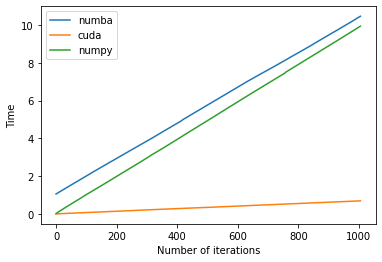

In [0]:
plt.plot(range(len(T_numba)), T_numba)
plt.plot(range(len(T_cuda)), T_cuda)
plt.plot(range(len(T_numpy)), T_numpy)
plt.xlabel('Number of iterations')
plt.ylabel('Time')
plt.legend(['numba','cuda','numpy'])